In [28]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
################################################################

### RK Edits usually come after single '###'

In [1]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"     

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=5)

In [3]:
## Asymmetric P matrix ##

def asymP(sig, n):

    return abs(normal(0, sig, (n, n))) ### "doubling-up" prob density by taking abs(normally distributed)???
                                        ### another distribution, but on the positive reals?

In [4]:
## Symmetric P matrix ##

def symP(sig, n):
    
    P = np.empty((n, n))
    for i in range(n):
        for j in range(i + 1):
            P[j][i] = P[i][j] = abs(normal(0, sig))
    
    return P

In [5]:
### Vectorized Symmetric P matrix
def symPvec(sig, n, k=1): # k, number of matrices to generate
    P = abs(normal(0,sig,(k,n,n)))
    P = np.maximum(P,np.transpose(P,(0,2,1))) #transpose each sub-P (only transpose last two dimensions)
    ### Is max an issue? Favors less probable p-values, I guess. Not QUITE normally dist'd 
                            ### after abs and this maximum. Effectively increases sigma?
    
    return P

In [6]:
def symPvec2(sig,n,k=1): ### This way does not use max, but slightly slower than symPvec
    P = abs(normal(0,sig,(k,n,n)))
    inds = np.tril_indices(n, k=-1)
    P[:,inds[1],inds[0]] = P[:,inds[0],inds[1]]
    
    return P

In [7]:
p = symPvec(1,4,2)
p.shape
p == np.transpose(p,(0,2,1)) # Vectorized P-generator works

p = symPvec2(1,4,2)
p == np.transpose(p,(0,2,1)) # other one also works


(2, 4, 4)

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]],

       [[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

In [6]:
### Check that mine is faster
import timeit

In [ ]:
%timeit symP(1,100)

In [104]:
%timeit symPvec(1,100)

356 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [108]:
%timeit symPvec2(1,100)

385 µs ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
sev = np.array([])
aev = np.array([]) 

## Parameters ##
  
n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I

## Production matrices ##

sP = symP(sig, n)
aP = asymP(sig, n)
#sPvec = symPvec(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                #produces this equilibrium


for k in range(2500): ### originally 5000
    ## Abundances ##
    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I

    LC = eps * c * s * I
    LD = np.zeros((n, n)) # DON'T REEVALUATE EVERY ITERATION

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states

In [31]:
rlb
r

63.83076486422923

294.69039039350645

In [9]:
#print(eigvals(sL),'\n') #length 40
# why all same real part in symmetric P

# DOMINANT EIGENVALUE, domEig
test = eigvals(aL)
#print(test)
reals = np.real(test)
domEV_ind = np.argmax(np.abs(reals)) #lazy way, assume negative eigvals?
domEV = test[domEV_ind]
print(domEV)

(-0.009220393596030992+0.6863397371252129j)


In [10]:
print(len(sev))
print(len(aev))

100000
100000


In [10]:
symP(1,5)

array([[1.49808, 0.50152, 0.27596, 0.04526, 0.6856 ],
       [0.50152, 0.88472, 1.18791, 0.85434, 1.61105],
       [0.27596, 1.18791, 1.45937, 0.50487, 1.30666],
       [0.04526, 0.85434, 0.50487, 0.84224, 1.24884],
       [0.6856 , 1.61105, 1.30666, 1.24884, 0.59343]])

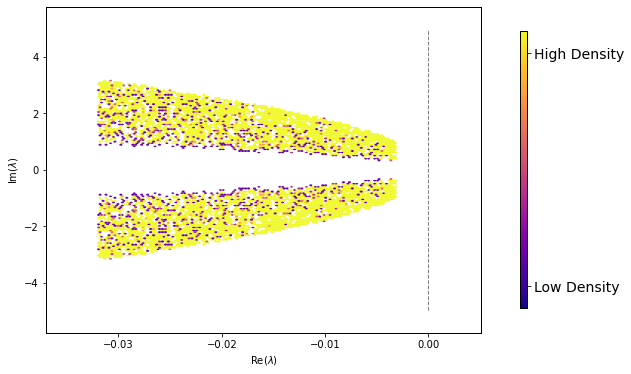

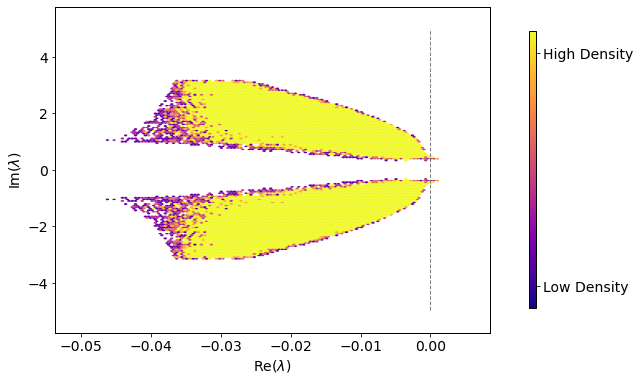

In [11]:
## Plot eigenvalues of linearized system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (10, 6))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white') 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 14}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)            
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

In [ ]:
### Instead, consider randomizing P(roduction matrix) and taking its Jacobian only at its corresponding steady state.

#make 2500xnxn array (2500 P matrices)
#make 2500xnx1 array (2500 Rstars)
# ""                 (2500 Sstars)

In [12]:
def extract_block_diags(A,block_size):
    '''
    A, square matrix whose (square) block diagonals of shape (block_size,block_size) are to be extracted
    
    This function has zero error handling. Make sure block_size fits the matrix, or whatever.
    '''
    block_diags = np.lib.stride_tricks.sliding_window_view(A,(block_size,block_size))[::block_size,::block_size]
    num_blocks = int(A.shape[0]/block_size)
    block_inds = list(range(num_blocks))
    
    return block_diags[block_inds,block_inds,:,:]    

In [13]:
### Resource-Competition Steady State vectors (R_star and S_star)
# Why are Rstars in the range of r_i in [1,100]??? Any way to normalize/nondimensionalize the model?

### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, these Fns will produce feasible Steady States

sP_ex = symPvec(1,20,10)

def R_star_gen(C,P,eps,mu): # P is actually 3-dimensional matrix (k nxn sub-P-matrices)
    '''
    Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
    that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
    No argument for number of sub-R_stars because that is inferred from 0th dimension of P argument.
    '''
    
    k = P.shape[0]
    n = P.shape[1]
    mu = np.tile(mu,(k,1,1))
    
    #C = np.tile(C,(k,1,1)) # OLD: stack C k times so that it can be dotted with each sub-Ps
                                # np.dot() does not broadcast, I think. Have to manually add 3rd dimension
        

    #A = np.linalg.inv(np.transpose(C,(0,2,1)))*(1/eps) # split up into A,v for readability
    A = np.linalg.inv(C.T)*(1/eps) # A is just nxn
    v = np.sum(np.transpose(P,(0,2,1)), 2).reshape(k,n,1) + mu #take row sums of P transpose, reshape to add 
    
    # How to pairwise dot an array of 2D matrices with array of column vectors?
    #R_star = np.dot(A,v) # OLD, for stacked C
    
    R_star = np.tensordot(A,v,axes=([1],[1])).reshape(n,k).T.reshape(k,n,1)
    #np.tensordot(I,b,axes=([1],[1])).reshape(2,3).T.reshape(3,2,1)
    return R_star
#mu = eps * Rstar (when specialized C)


mu_ex = np.ones(n).reshape(20,1)

R_star_ex = R_star_gen(C,sP_ex,eps,(mu_ex*1))
R_star_ex.shape


(10, 20, 1)

In [15]:
def S_star_gen(C,P,R_star,rho):
    k = P.shape[0]
    n = P.shape[1]
        
    # How get (k,n,n) array of R_diags, each k a diagonal array with R_star k as its entries?
    # fill main diagonal with flattened R_stars (it will be k*n x k*n), then extract the k nxn block main diagonal matrices
        # HOW EXTRACT BLOCK DIAGONALS IN NUMPY??????
        # Try sliding windows with slicing
        
        # Now, we have extract_block_diags()
    
    R_diag = np.zeros((k*n,k*n))
    np.fill_diagonal(R_diag, R_star.reshape(k*n,))
    # now, R_diag is big array
    R_diag = extract_block_diags(R_diag, n) # get each R_diag in (k,n,n)-shaped array
    
    ### FIX THIS LATER FOR NON-IDENTITY C ################################
    #  RC = np.dot(R_diag, C) # real way would be sth like this
    RC = R_diag
    
    A = np.linalg.inv(RC - P) # pairwise subtract RC and P
    print(A.shape)
    #S_star = np.dot(A, rho)  # in a perfect world, this is the answer
    
    # this time, we have many different sub-A and constant rho
    S_star = np.tensordot(A,rho.reshape(1,n,1),axes=([2],[1])) #.reshape(n,k).T.reshape(k,n,1) # we do not live in a perfect world

    return S_star.reshape(k,n,1)

rho_ex = np.ones(n).reshape(20,1)
S_star_ex = S_star_gen(C,sP_ex,R_star_ex,rho_ex)

S_star_ex.shape

(10, 20, 20)


(10, 20, 1)

In [264]:
x = np.random.rand(4*3*2).reshape(4,3,2)
x
v = np.arange(2).reshape(1,2,1)
v

array([[[0.96317, 0.03247],
        [0.41094, 0.68632],
        [0.82761, 0.55654]],

       [[0.91987, 0.0175 ],
        [0.08427, 0.02389],
        [0.2948 , 0.03446]],

       [[0.37971, 0.97647],
        [0.71401, 0.05448],
        [0.85798, 0.74828]],

       [[0.94376, 0.18831],
        [0.48438, 0.84237],
        [0.50942, 0.518  ]]])

array([[[0],
        [1]]])

In [274]:
z = np.tensordot(x,v,axes=([2],[1]))
z
z.reshape(4,3,1)


array([[[[0.03247]],

        [[0.68632]],

        [[0.55654]]],


       [[[0.0175 ]],

        [[0.02389]],

        [[0.03446]]],


       [[[0.97647]],

        [[0.05448]],

        [[0.74828]]],


       [[[0.18831]],

        [[0.84237]],

        [[0.518  ]]]])

array([[[0.03247],
        [0.68632],
        [0.55654]],

       [[0.0175 ],
        [0.02389],
        [0.03446]],

       [[0.97647],
        [0.05448],
        [0.74828]],

       [[0.18831],
        [0.84237],
        [0.518  ]]])

In [35]:
x = np.identity(9)
d = extract_block_diags(x,3) # it work
d

array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]])

In [38]:
k=10

In [39]:
# Check that R_star_gen works???

v=(np.sum(np.transpose(sP_ex,(0,2,1)), 2).reshape(k,n,1) + np.tile(mu_ex,(k,1,1))) #10x20x1
A = np.linalg.inv(np.transpose(np.tile(C,(k,1,1)),(0,2,1)))*(1/eps) # 10x20x20

X = np.tensordot(A,v,axes=([2],[1]))
X.shape
X[0,:,1,:]

#np.sum(sP_ex[0,:,:].T,1).shape
#check against manual calculation of first R_star
#np.all(np.dot(np.linalg.inv(C)/eps,np.sum(sP_ex[0,:,:].T,1).reshape(20,1) + mu_ex) == X[0,:,0,:])

#np.all(np.dot(np.linalg.inv(C)/eps,np.sum(sP_ex[1,:,:].T,1).reshape(20,1) + mu_ex) == X[1,:,1,:])

(10, 20, 10, 1)

array([[ 82.13621],
       [ 79.72789],
       [ 93.4421 ],
       [ 83.8318 ],
       [ 82.04604],
       [106.83662],
       [ 94.57909],
       [ 82.03602],
       [ 94.41949],
       [ 92.45788],
       [103.24967],
       [ 98.8627 ],
       [ 86.78045],
       [ 84.00775],
       [107.47408],
       [106.36714],
       [ 71.34684],
       [ 77.97074],
       [103.10706],
       [ 91.77206]])

In [40]:
b = np.random.rand(6).reshape(3,2,1)
b

I = np.identity(2) #2x2
b.shape # 3x2x1

out = np.tensordot(I,b,axes=([1],[1]))
#out
out = out.reshape(2,3)
#out
out = out.T.reshape(3,2,1)
out.shape
out

### THIS IS HOW YOU DOT A BUNCH OF MATRICES (only works for same matrix tho, only vary vector)

array([[[0.83595],
        [0.00732]],

       [[0.54736],
        [0.35862]],

       [[0.115  ],
        [0.41956]]])

(3, 2, 1)

(3, 2, 1)

array([[[0.83595],
        [0.00732]],

       [[0.54736],
        [0.35862]],

       [[0.115  ],
        [0.41956]]])

In [61]:
### Now, can generate k P matrices shape (k,n,n) and the corresponding R/S_stars for Jacobian at equilibrium

### MAKE INTO A FUCNTION

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##

n   = 20      # number of species AND number of resrcs
k = 750        # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 25      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
#mu = np.random.unif(0,1,n) 
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
#rho = np.random.unif(0,1,n)
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I


#sPvec = symPvec(sig, n)


### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibrium
    ### Then find dominant eigenvalues.

LD = np.zeros((k, n, n)) # DON'T REEVALUATE EVERY ITERATION

## Production matrices ##

sP = symPvec2(sig, n, k) # VECTORIZE the return value/FNs arg to return 'm' such matrices (better than for loop) 
#aP = asymP(sig, n, ) #save asym for later


## Equilibrium Abundances ##

sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

#aR_star = R_star_gen(C,aP, eps, mu)
#aS_star = S_star_gen(C,aP, aR_star, rho)

## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | aLB]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
#aLA = -c * aS_star * I
#aLB = aP - c * aR_star * I
#aLC = eps * c * aS_star * I


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
#aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))

## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL))
#aEVs = np.append(aEVs, eigvals(aL))

(750, 20, 20)


(10, 40, 40)

In [104]:
# Try with random P with sig =1 (above), then try sig=5

In [ ]:
sEVs.shape
np.max(np.abs(sEVs))

In [43]:
sEVs[sEVs>0] # all negative

array([], dtype=complex128)

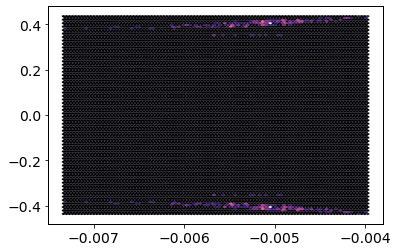

In [50]:
cmap = mpl.cm.get_cmap("magma").copy()
cmap.set_under(color = 'white') 
plt.hexbin(sEVs.real, sEVs.imag, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???


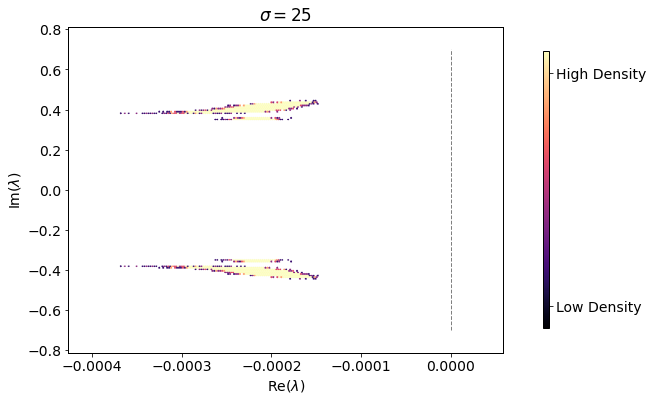

In [63]:
### Plot Eigenvalues of Various Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho)


x = sEVs.real
y = sEVs.imag

plt.rcParams["axes.edgecolor"] = "black" 
plt.rcParams["axes.linewidth"] = 1 

fig, ax = plt.subplots(figsize = (10, 6))

#cmap = plt.cm.viridis_r  ### old, gets an error
cmap = mpl.cm.get_cmap("magma").copy()
cmap.set_under(color = 'white') 

plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

font = {'size' : 14}
plt.rc('font', **font)

plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')

plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
### originally, (10**(-8), 2.0)

xmin, xmax = plt.xlim()
nxm = (xmax - xmin) / 10 ### def'n some padding/margins
plt.xlim((xmin - nxm, xmax + nxm))


# ### Adjusting Re axis tick marks
# if i==0: ### symmetric P
#     loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
#     ax.xaxis.set_major_locator(loc)            
# if i==1: ### asymetric P
#     loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
#     ax.xaxis.set_major_locator(loc)


ymin, ymax = plt.ylim()
nym = (ymax - ymin) / 3
plt.ylim((ymin - nym, ymax + nym))
plt.title(r'$\sigma={}$'.format(sig))

cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
locs = cb.get_ticks()
tl = locs[-1] * 2 / 25
cb.set_ticks([tl, locs[-1] - tl])
cb.set_ticklabels(['Low Density', 'High Density'])

plt.show();

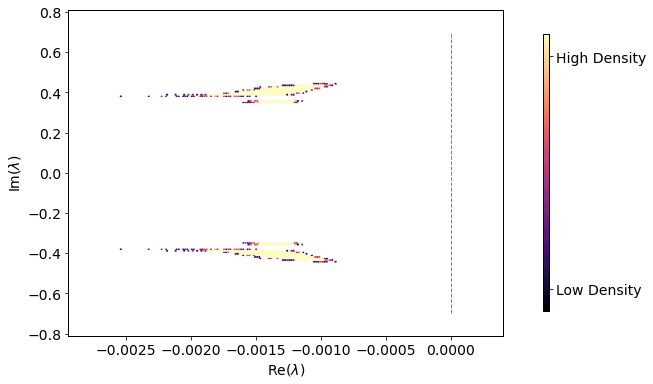

In [48]:
sEVs.real.shape
sEVs.imag.shape

(400,)

(400,)

In [221]:
### This just gives percent of total eigenvalues that suggest (in)stability
    ### Would have to keep them separated by the sub-P that they came from to determine the "probability" of stability
aEVs_reals = aEVs.real
ratio_unstable = np.sum(aEVs_reals>0)/aEVs.size
ratio_stable = np.sum(aEVs_reals<0)/aEVs.size
ratio_unstable
ratio_stable
ratio_unstable+ratio_stable

array([False, False, False, ..., False, False, False])

0.04237

0.95763

1.0

In [215]:
aEVs.real

array([-0.0049 , -0.0049 , -0.00529, ..., -0.00604, -0.00571, -0.00571])

In [20]:
###########################################################
############ Start of Stability Measures ##################
###########################################################

In [64]:
### Arnoldi Stability Measures
n = 20 #repeated
import scipy as sp # for matrix exponential

# Return Rates
def R_avg(x, t, u): #requires, current displacement 'x', current time 't', perturbation 'u'
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [65]:
### Generate uniformly distributed unit-length  perturbation 'u' ; does this still count as 'uniform'???

# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    #u = np.random.uniform(-1, 1, n)
    u = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return u/np.linalg.norm(u,2) # does this provide uniformly distributed pert direction? They say so. 
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

# Perturbation covariance matrix Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equil. populations not being considered in perturbation distribution

In [67]:
### Generate 'u' such that u_i proportional to N*_i
Nstar = np.random.rand(n) #just an example Nstar
Nstar = Nstar/np.linalg.norm(Nstar,2)

LAM = np.sum(np.square(Nstar)) #lambda, from Arnoldi Appendix E
Cov_prop = np.diag(np.square(Nstar)/LAM) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

#Appendix E says the following:
def u_gen_prop(n, Nstar): # Generate perturbation from a population-proportional distribution
    v = np.random.normal(0,1,n)
    D = np.diag(Nstar)
    w = D*v # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [ ]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(sp.linalg.expm(A*t)*Cov*sp.linalg.expm(A.T*t)))

def R_avg_median(A,Cov,t): # average return rate
    return -(np.log(np.trace(sp.linalg.expm(A*t)*Cov*sp.linalg.expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [ ]:
equil = np.concatenate((R_star_ex[0,:,:],S_star_ex[0,:,:]))

equil.shape

In [74]:
u_ex = u_gen_prop(n,equil)
np.linalg.norm(u_ex,2) #cool
LAM_ex = np.sum(np.square(equil))
Cov_ex = np.diag(np.square(equil)/LAM)

1.0

In [192]:
### Return time
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

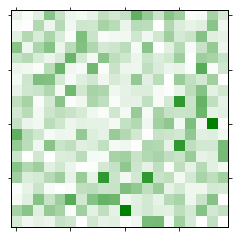

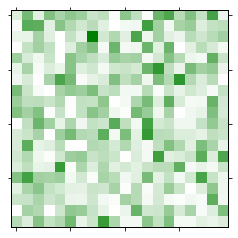

In [132]:
### Plot Grid Representing Production Matrix P ###

for i, M in enumerate([sP, aP]):
    
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'green'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                    cmap=c_map)

    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis = 'both',          
                    which = 'both',      
                    bottom = 'off',      
                    top = 'off',         
                    labelbottom = 'off',
                    left = 'off',
                    right = 'off')

    ax.grid(False)
plt.show();

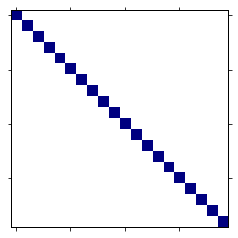

In [133]:
### Plot grid representing consumption C ###

C = c*I

for M in [C]:
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'navy'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                        cmap=c_map)


    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis='both',          
                    which='both',      
                    bottom='off',      
                    top='off',         
                    labelbottom='off',
                    left='off',
                    right='off')

    ax.grid(False)


In [ ]:
### Diversity Indices

def alpha_???(N): # population vector N
    